In [85]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from  sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pprint
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

%matplotlib inline


class KNN:
    def __init__(self, train_features, train_labels):
        self.train_features = train_features
        self.train_labels = train_labels

    def get_distances(self, query_features):
        diff = query_features - self.train_features
        distances = np.sqrt(np.sum(diff ** 2, axis=1))
        return distances

    def get_k_nearest_neighbours(self, k, query_features):
        distances = self.get_distances(query_features)
        neighbours = np.argsort(distances)[0:k]
        return neighbours

    def predict(self, k, query_features):
        neighbours = self.get_k_nearest_neighbours(k, query_features)
        y_predictions = self.train_labels[neighbours]
        counter = Counter(y_predictions)
        y_predict = counter.most_common(1)[0][0]
        return y_predict


def z_normalize(train_features, test_features):
    mean  = np.mean(train_features, axis=0)
    std = np.std(train_features, axis=0)
    return ((train_features - mean) / std),((test_features - mean) / std)


def get_accuracy(test_labels, predictions):
    correct_results = np.sum(np.isclose(test_labels, predictions))
    return correct_results / float(len(test_labels))


def get_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    print "Reading data from [{}] with Shape:{}".format(filename, data.shape)
    return data


def k_fold_generator(X, y, k_fold):
    subset_size = (X.shape[0]) / k_fold
    for k in range(1, k_fold + 1):
        start_valid = (k - 1) * subset_size
        end_valid = start_valid + subset_size
        valid_rows = np.arange(start_valid, end_valid)
        train_rows = [x for x in range(X.shape[0]) if x not in valid_rows]
        X_train = X[train_rows, :]
        X_valid = X[valid_rows, :]
        y_train = y[train_rows]
        y_valid = y[valid_rows]
        yield X_train, y_train, X_valid, y_valid


def part_a():
    train_features = get_data("spambase/spambase_train.txt")
    train_labels = get_data("spambase/spambase_train_label.txt")
    test_features = get_data("spambase/spambase_test.txt")
    test_labels = get_data("spambase/spambase_test_label.txt")

    knn = KNN(train_features=train_features, train_labels=train_labels)

    k_values = [1, 5, 11, 21, 41, 61, 81, 101, 201, 401]
    accuracy = []
    for k in k_values:
        predictions = []
        for i in range(len(test_features)):
            predictions.append(knn.predict(k, test_features[i]))
        accuracy.append(get_accuracy(test_labels, predictions))

    fig, ax = plt.subplots()
    ax.plot(k_values, accuracy, 'bo-')
    ax.set_ylabel("accuracy")
    ax.set_xlabel("k")
    ax.set_title("KNN: k vs. accuracy")
    
    print"###########################Output###########################"

    for i,k in enumerate(k_values):
        print "k = {}, accuracy = {}".format(k_values[i],accuracy[i])
    
    max_index = np.argmax(np.array(accuracy))
    print "Optimal k={} with accuray={}".format(k_values[max_index],accuracy[max_index])


def part_b():
    train_features = get_data("spambase/spambase_train.txt")
    train_labels = get_data("spambase/spambase_train_label.txt")
    test_features = get_data("spambase/spambase_test.txt")
    test_labels = get_data("spambase/spambase_test_label.txt")

    # Normalize
    train_features,test_features  = z_normalize(train_features,test_features)

    knn = KNN(train_features=train_features, train_labels=train_labels)

    k_values = [1, 5, 11, 21, 41, 61, 81, 101, 201, 401]
    accuracy = []
    for k in k_values:
        predictions = []
        for i in range(len(test_features)):
            predictions.append(knn.predict(k, test_features[i]))
        accuracy.append(get_accuracy(test_labels, predictions))

    fig, ax = plt.subplots(1)
    # fig.set_size_inches(6, 8)
    ax.plot(k_values, accuracy, 'bo-')
    # ax.annotate('k=5',xy=(5,accuracy[1]))
    ax.set_ylabel("accuracy")
    ax.set_xlabel("k")
    ax.set_title("KNN: k vs. accuracy")
    print"###########################Output###########################"

    for i,k in enumerate(k_values):
        print "k = {}, accuracy = {}".format(k_values[i],accuracy[i])
    
    max_index = np.argmax(np.array(accuracy))
    print "Optimal k={} with accuray={}".format(k_values[max_index],accuracy[max_index])



def part_c():
    train_features = get_data("spambase/spambase_train.txt")
    train_labels = get_data("spambase/spambase_train_label.txt")
    test_features = get_data("spambase/spambase_test.txt")
    test_labels = get_data("spambase/spambase_test_label.txt")

    # Normalize
    train_features, test_features = z_normalize(train_features,test_features)

    knn = KNN(train_features=train_features, train_labels=train_labels)
    k_values = [1, 5, 11, 21, 41, 61, 81, 101, 201, 401]
    result = {}
    print"###########################Output###########################"
    for i in range(50):
        predictions = []
        for k in k_values:
            predictions.append(knn.predict(k, test_features[i]))
        result[i + 1] = map(lambda x: "spam" if x == 1.0 else "no", predictions)
    pprint.pprint(result, width=150)
    print "#########################################################"


def part_d():
    train_features = get_data("spambase/spambase_train.txt")
    train_labels = get_data("spambase/spambase_train_label.txt")
    test_features = get_data("spambase/spambase_test.txt")
    test_labels = get_data("spambase/spambase_test_label.txt")
    train_features, test_features = z_normalize(train_features,test_features)
    k_values = np.arange(1,150)
    cv = []
    score = []
    for k in k_values:
        neigh = KNeighborsClassifier(n_neighbors=k)
        score.append(cross_val_score(neigh, train_features, train_labels, cv=10))
    # pprint.pprint(score)
    accuracy_on_k_with_skl = np.mean(np.array(score), axis=1)
    # pprint.pprint(accuracy_on_k_with_skl )
    optimal_k_index_with_skl = np.argmax(accuracy_on_k_with_skl)
    print "Optimal Value with sklearn for K is [{}] with Accuracy [{}]".format(k_values[optimal_k_index_with_skl],
                                                                               accuracy_on_k_with_skl[
                                                                                   optimal_k_index_with_skl])


## Exercise 2.a

Reading data from [spambase/spambase_train.txt] with Shape:(2300, 57)
Reading data from [spambase/spambase_train_label.txt] with Shape:(2300,)
Reading data from [spambase/spambase_test.txt] with Shape:(2301, 57)
Reading data from [spambase/spambase_test_label.txt] with Shape:(2301,)
###########################Output###########################
k = 1, accuracy = 0.751847023033
k = 5, accuracy = 0.754889178618
k = 11, accuracy = 0.764884832681
k = 21, accuracy = 0.746631899174
k = 41, accuracy = 0.752281616688
k = 61, accuracy = 0.737505432421
k = 81, accuracy = 0.726640591047
k = 101, accuracy = 0.728813559322
k = 201, accuracy = 0.731421121252
k = 401, accuracy = 0.719687092568
Optimal k=11 with accuray=0.764884832681


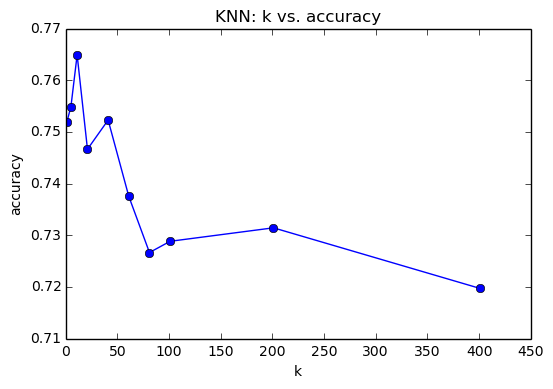

In [86]:
part_a()

## Exercise 2.b

Reading data from [spambase/spambase_train.txt] with Shape:(2300, 57)
Reading data from [spambase/spambase_train_label.txt] with Shape:(2300,)
Reading data from [spambase/spambase_test.txt] with Shape:(2301, 57)
Reading data from [spambase/spambase_test_label.txt] with Shape:(2301,)
###########################Output###########################
k = 1, accuracy = 0.856149500217
k = 5, accuracy = 0.870056497175
k = 11, accuracy = 0.878748370274
k = 21, accuracy = 0.884398087788
k = 41, accuracy = 0.885267275098
k = 61, accuracy = 0.882659713168
k = 81, accuracy = 0.877444589309
k = 101, accuracy = 0.875271621034
k = 201, accuracy = 0.860060843112
k = 401, accuracy = 0.83963494133
Optimal k=41 with accuray=0.885267275098


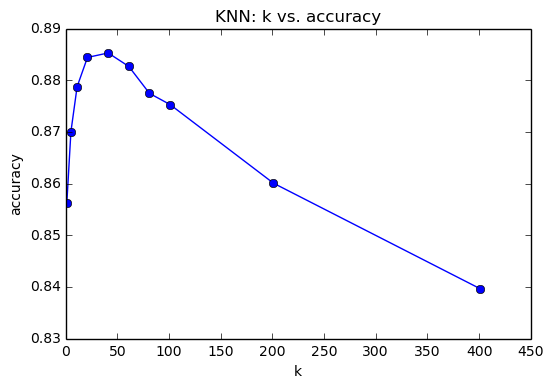

In [87]:
part_b()

## Exercise 2.c

In [88]:
part_c()

Reading data from [spambase/spambase_train.txt] with Shape:(2300, 57)
Reading data from [spambase/spambase_train_label.txt] with Shape:(2300,)
Reading data from [spambase/spambase_test.txt] with Shape:(2301, 57)
Reading data from [spambase/spambase_test_label.txt] with Shape:(2301,)
###########################Output###########################
{1: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'no', 'no'],
 2: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'no', 'no'],
 3: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
 4: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
 5: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
 6: ['spam', 'spam', 'no', 'spam', 'no', 'no', 'no', 'no', 'spam', 'spam'],
 7: ['spam', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'],
 8: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
 9:

## Exercise 2.d

#### What can you conclude by comparing and examining the KNN performance in (a) and (b)?
Findings from part a) and part b):

1. Part A -->> Optimal K=11 , Accuracy = 0.76488483268144281
2. Part B -->> Optimal K=41 , Accuracy = 0.88526727509778358

Looking at the solutions we can say that, as input data for part b) is normalized and makes it better for KNN because with  normalizing we are centering and scaling the data, thus all the features contribute the same to the distance metric and our data becomes more dense which is always better.


#### Give a method to select the optimal k for the KNN algorithm.
A good method to find the optimal k would be Cross Validation. 

- We can divide the input data in x folds
- Run each fold with possible values of k neighbors.
- Find the average of accuracy for each fold on for all the k neighbors
- Take max on all k